In [5]:
%matplotlib inline


# Backtracking on sloped terrain

Modeling backtracking for single-axis tracker arrays on sloped terrain.


Tracker systems use backtracking to avoid row-to-row shading when the
sun is low in the sky. The backtracking strategy orients the modules exactly
on the boundary between shaded and unshaded so that the modules are oriented
as much towards the sun as possible while still remaining unshaded.
Unlike the true-tracking calculation (which only depends on solar position),
calculating the backtracking angle requires knowledge of the relative spacing
of adjacent tracker rows. This example shows how the backtracking angle
changes based on a vertical offset between rows caused by sloped terrain.
It uses :py:func:`pvlib.tracking.calc_axis_tilt` and
:py:func:`pvlib.tracking.calc_cross_axis_tilt` to calculate the necessary
array geometry parameters and :py:func:`pvlib.tracking.singleaxis` to
calculate the backtracking angles.

## Angle conventions

First let's go over the sign conventions used for angles. In contrast to
fixed-tilt arrays where the azimuth is that of the normal to the panels, the
convention for the azimuth of a single-axis tracker is along the tracker
axis. Note that the axis azimuth is a property of the array and is distinct
from the azimuth of the panel orientation, which changes based on tracker
rotation angle. Because the tracker axis points in two directions, there are
two choices for the axis azimuth angle, and by convention (at least in the
northern hemisphere), the more southward angle is chosen:

<img src="file://../_images/tracker_azimuth_angle_convention.png" alt="Image showing the azimuth convention for single-axis tracker arrays." width="500" align="center">

Note that, as with fixed-tilt arrays, the axis azimuth is determined as the
angle clockwise from north. The azimuth of the terrain's slope is also
determined as an angle clockwise from north, pointing in the direction
of falling slope. So for example, a hillside that slopes down to the east
has an azimuth of 90 degrees.

Using the axis azimuth convention above, the sign convention for tracker
rotations is given by the
`right-hand rule <https://en.wikipedia.org/wiki/Right-hand_rule>`_.
Point the right hand thumb along the axis in the direction of the axis
azimuth and the fingers curl in the direction of positive rotation angle:

<img src="file://../_images/tracker_rotation_angle_convention.png" alt="Image showing the rotation sign convention for single-axis trackers." width="500" align="center">

So for an array with ``axis_azimuth=180`` (tracker axis aligned perfectly
north-south), pointing the right-hand thumb along the axis azimuth has the
fingers curling towards the west, meaning rotations towards the west are
positive and rotations towards the east are negative.

The ground slope itself is always positive, but the component of the slope
perpendicular to the tracker axes can be positive or negative. The convention
for the cross-axis slope angle follows the right-hand rule: align
the right-hand thumb along the tracker axis in the direction of the axis
azimuth and the fingers curl towards positive angles. So in this example,
with the axis azimuth coming out of the page, an east-facing, downward slope
is a negative rotation from horizontal:

<img src="file://../_images/ground_slope_angle_convention.png" alt="Image showing the ground slope sign convention." width="500" align="center">




## Rotation curves

Now, let's plot the simple case where the tracker axes are at right angles
to the direction of the slope.  In this case, the cross-axis tilt angle
is the same as the slope of the terrain and the tracker axis itself is
horizontal.



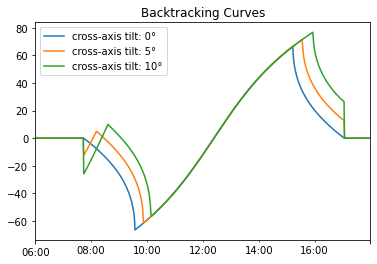

In [6]:
from pvlib import solarposition, tracking
import pandas as pd
import matplotlib.pyplot as plt

# PV system parameters
tz = 'US/Eastern'
lat, lon = 40, -80
gcr = 0.4

# calculate the solar position
times = pd.date_range('2019-01-01 06:00', '2019-01-01 18:00', closed='left',
                      freq='1min', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)

# compare the backtracking angle at various terrain slopes
fig, ax = plt.subplots()
for cross_axis_tilt in [0, 5, 10]:
    tracker_data = tracking.singleaxis(
        apparent_zenith=solpos['apparent_zenith'],
        apparent_azimuth=solpos['azimuth'],
        axis_tilt=0,  # flat because the axis is perpendicular to the slope
        axis_azimuth=180,  # N-S axis, azimuth facing south
        max_angle=90,
        backtrack=True,
        gcr=gcr,
        cross_axis_tilt=cross_axis_tilt)

    # tracker rotation is undefined at night
    backtracking_position = tracker_data['tracker_theta'].fillna(0)
    label = 'cross-axis tilt: {}°'.format(cross_axis_tilt)
    backtracking_position.plot(label=label, ax=ax)

plt.legend()
plt.title('Backtracking Curves')
plt.show()

This plot shows how backtracking changes based on the slope between rows.
For example, unlike the flat-terrain backtracking curve, the sloped-terrain
curves do not approach zero at the end of the day. Because of the vertical
offset between rows introduced by the sloped terrain, the trackers can be
slightly tilted without shading each other.

Now let's examine the general case where the terrain slope makes an
inconvenient angle to the tracker axes. For example, consider an array
with north-south axes on terrain that slopes down to the south-south-east.
Assuming the axes are installed parallel to the ground, the northern ends
of the axes will be higher than the southern ends. But because the slope
isn't purely parallel or perpendicular to the axes, the axis tilt and
cross-axis tilt angles are not immediately obvious. We can use pvlib
to calculate them for us:



In [7]:
# terrain slopes 10 degrees downward to the south-south-east. note: because
# slope_azimuth is defined in the direction of falling slope, slope_tilt is
# always positive.
slope_azimuth = 155
slope_tilt = 10
axis_azimuth = 180  # tracker axis is still N-S

# calculate the tracker axis tilt, assuming that the axis follows the terrain:
axis_tilt = tracking.calc_axis_tilt(slope_azimuth, slope_tilt, axis_azimuth)

# calculate the cross-axis tilt:
cross_axis_tilt = tracking.calc_cross_axis_tilt(slope_azimuth, slope_tilt,
                                                axis_azimuth, axis_tilt)

print('Axis tilt:', '{:0.01f}°'.format(axis_tilt))
print('Cross-axis tilt:', '{:0.01f}°'.format(cross_axis_tilt))

Axis tilt: 9.1°
Cross-axis tilt: -4.2°


And now we can pass use these values to generate the tracker curve as
before:



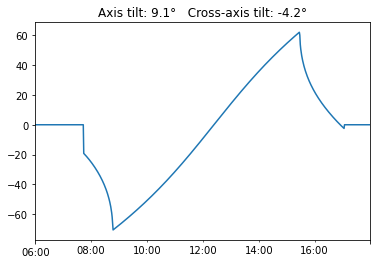

In [8]:
tracker_data = tracking.singleaxis(
    apparent_zenith=solpos['apparent_zenith'],
    apparent_azimuth=solpos['azimuth'],
    axis_tilt=axis_tilt,  # no longer flat because the terrain imparts a tilt
    axis_azimuth=axis_azimuth,
    max_angle=90,
    backtrack=True,
    gcr=gcr,
    cross_axis_tilt=cross_axis_tilt)

backtracking_position = tracker_data['tracker_theta'].fillna(0)
backtracking_position.plot()

title_template = 'Axis tilt: {:0.01f}°   Cross-axis tilt: {:0.01f}°'
plt.title(title_template.format(axis_tilt, cross_axis_tilt))
plt.show()

Note that the backtracking curve is roughly mirrored compared with the
earlier example -- it is because the terrain is now sloped somewhat to the
east instead of west.

